# Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
from scipy import signal
import warnings
warnings.filterwarnings("ignore")

In [20]:
# Set plot style
plt.style.use('fivethirtyeight')
sns.set_context("notebook", font_scale=1.2)

# Load Data

In [21]:
# Load daily data
hebrew_daily = pd.read_csv("../data/sentiment_temporal/hebrew_sentiment_daily.csv")
arabic_daily = pd.read_csv("../data/sentiment_temporal/arabic_sentiment_daily.csv")

# Load hourly data
hebrew_hourly = pd.read_csv("../data/sentiment_temporal/hebrew_sentiment_hourly.csv")
arabic_hourly = pd.read_csv("../data/sentiment_temporal/arabic_sentiment_hourly.csv")

# Load weekly data
hebrew_weekly = pd.read_csv("../data/sentiment_temporal/hebrew_sentiment_weekly.csv")
arabic_weekly = pd.read_csv("../data/sentiment_temporal/arabic_sentiment_weekly.csv")

# Display data info
print("Hebrew Daily Data:")
print(f"Shape: {hebrew_daily.shape}")
print(f"Date range: {hebrew_daily['time_period'].min()} to {hebrew_daily['time_period'].max()}")
print("\nArabic Daily Data:")
print(f"Shape: {arabic_daily.shape}")
print(f"Date range: {arabic_daily['time_period'].min()} to {arabic_daily['time_period'].max()}")


Hebrew Daily Data:
Shape: (505, 13)
Date range: 2023-10-06 to 2025-02-21

Arabic Daily Data:
Shape: (505, 13)
Date range: 2023-10-06 to 2025-02-21


# Change Point Detection

## Change Point Detection with CUSUM
CUSUM (Cumulative Sum) is a sequential analysis technique used to detect changes in the mean of a process. It's particularly effective for detecting sudden shifts in time series data.


In [22]:
def cusum_changepoint_detection(data, threshold=1.0, drift=0.0):
    """
    Performs CUSUM (Cumulative Sum) change point detection on time series data.

    Parameters:
    -----------
    data : array-like
        The time series data to analyze
    threshold : float, default=1.0
        Detection threshold for change points
    drift : float, default=0.0
        Drift parameter to prevent false alarms

    Returns:
    --------
    cp_indices : list
        Indices of detected change points
    cusum_pos : array
        Positive CUSUM values
    cusum_neg : array
        Negative CUSUM values
    """
    data = np.asarray(data)

    # Normalize data
    mean = np.mean(data)
    std = np.std(data)
    if std == 0:
        std = 1.0  # Avoid division by zero

    normalized_data = (data - mean) / std

    # Initialize CUSUM values
    cusum_pos = np.zeros(len(normalized_data))
    cusum_neg = np.zeros(len(normalized_data))

    # Calculate CUSUM values
    for i in range(1, len(normalized_data)):
        cusum_pos[i] = max(0, cusum_pos[i-1] + normalized_data[i] - drift)
        cusum_neg[i] = max(0, cusum_neg[i-1] - normalized_data[i] - drift)

    # Detect change points
    cp_indices = []

    for i in range(1, len(normalized_data)):
        if cusum_pos[i] > threshold or cusum_neg[i] > threshold:
            cp_indices.append(i)
            # Reset CUSUM after detecting a change point
            cusum_pos[i] = 0
            cusum_neg[i] = 0

    return cp_indices, cusum_pos, cusum_neg

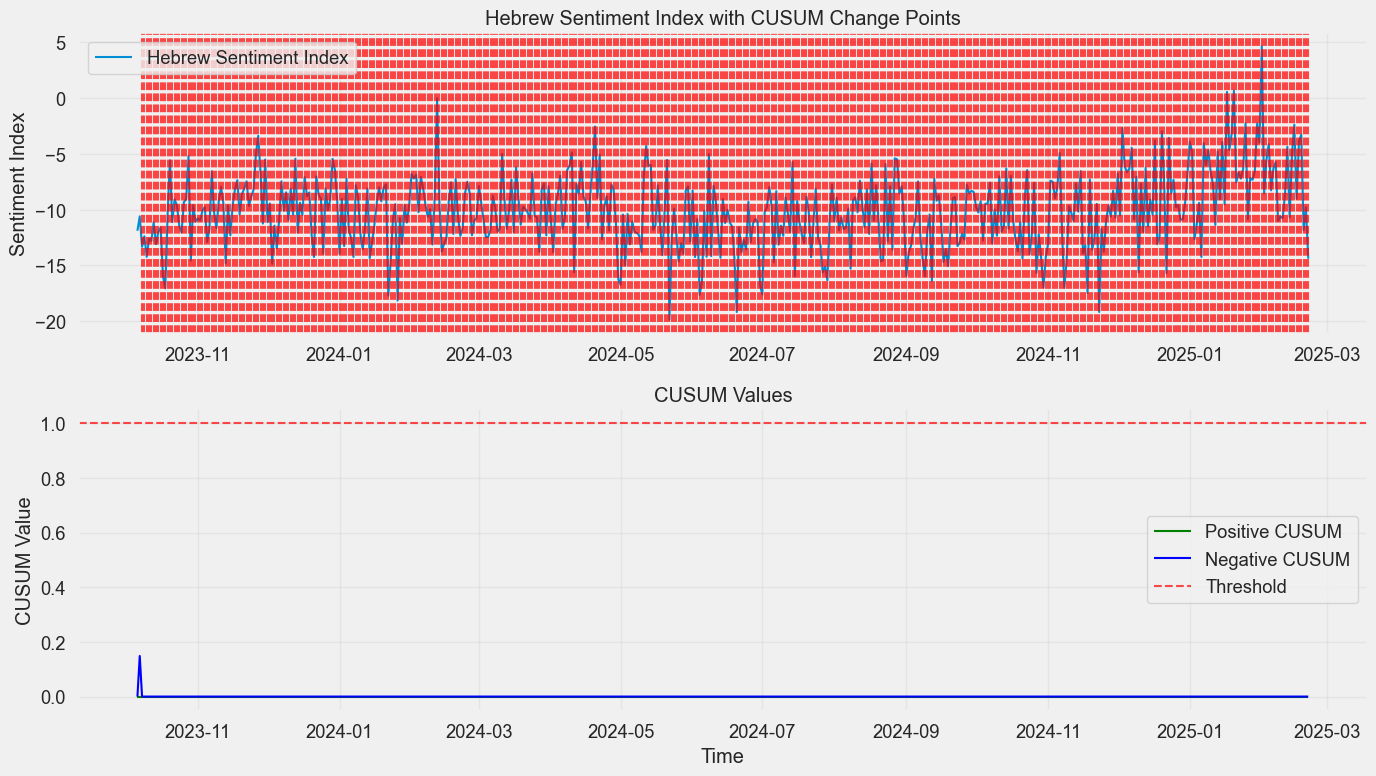

Detected 503 change points in Hebrew sentiment:
- 2023-10-08: Sentiment changed from -10.594 to -13.327
- 2023-10-09: Sentiment changed from -13.327 to -12.380
- 2023-10-10: Sentiment changed from -12.380 to -14.225
- 2023-10-11: Sentiment changed from -14.225 to -12.598
- 2023-10-12: Sentiment changed from -12.598 to -12.802
- 2023-10-13: Sentiment changed from -12.802 to -11.130
- 2023-10-14: Sentiment changed from -11.130 to -13.089
- 2023-10-15: Sentiment changed from -13.089 to -12.000
- 2023-10-16: Sentiment changed from -12.000 to -11.589
- 2023-10-17: Sentiment changed from -11.589 to -15.961
- 2023-10-18: Sentiment changed from -15.961 to -17.045
- 2023-10-19: Sentiment changed from -17.045 to -10.362
- 2023-10-20: Sentiment changed from -10.362 to -5.568
- 2023-10-21: Sentiment changed from -5.568 to -11.111
- 2023-10-22: Sentiment changed from -11.111 to -9.072
- 2023-10-23: Sentiment changed from -9.072 to -9.589
- 2023-10-24: Sentiment changed from -9.589 to -11.423
- 2023

In [23]:
# Let's apply CUSUM to Hebrew sentiment data
hebrew_metric = 'sentiment_index'
hebrew_ts = hebrew_daily[hebrew_metric].values
timestamps = pd.to_datetime(hebrew_daily['time_period'])

# Apply CUSUM with default parameters
hebrew_cp, hebrew_cusum_pos, hebrew_cusum_neg = cusum_changepoint_detection(
    hebrew_ts, threshold=1.0, drift=0.0
)

# Visualize the change points
plt.figure(figsize=(14, 8))

# Plot the original time series
plt.subplot(211)
plt.plot(timestamps, hebrew_ts, label='Hebrew Sentiment Index')

# Highlight change points
for cp in hebrew_cp:
    if cp < len(timestamps):
        plt.axvline(x=timestamps[cp], color='r', linestyle='--', alpha=0.7)

plt.title('Hebrew Sentiment Index with CUSUM Change Points')
plt.ylabel('Sentiment Index')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot the CUSUM values
plt.subplot(212)
plt.plot(timestamps, hebrew_cusum_pos, 'g-', label='Positive CUSUM')
plt.plot(timestamps, hebrew_cusum_neg, 'b-', label='Negative CUSUM')
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Threshold')

plt.title('CUSUM Values')
plt.xlabel('Time')
plt.ylabel('CUSUM Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detected change points
print(f"Detected {len(hebrew_cp)} change points in Hebrew sentiment:")
for cp in hebrew_cp:
    if cp < len(timestamps):
        print(f"- {timestamps[cp].date()}: Sentiment changed from {hebrew_ts[cp-1]:.3f} to {hebrew_ts[cp]:.3f}")

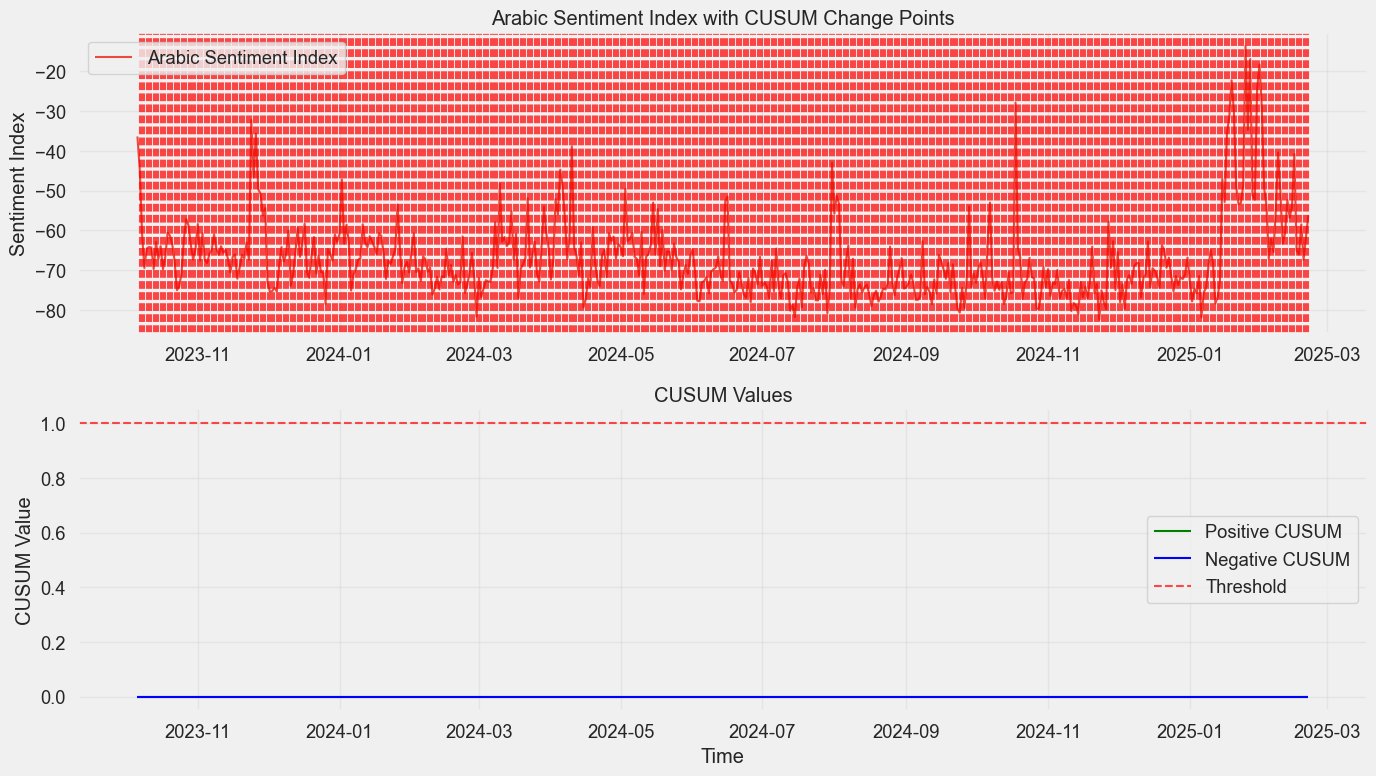

Detected 504 change points in Arabic sentiment:
- 2023-10-07: Sentiment changed from -36.387 to -44.668
- 2023-10-08: Sentiment changed from -44.668 to -60.907
- 2023-10-09: Sentiment changed from -60.907 to -69.476
- 2023-10-10: Sentiment changed from -69.476 to -64.583
- 2023-10-11: Sentiment changed from -64.583 to -64.189
- 2023-10-12: Sentiment changed from -64.189 to -64.319
- 2023-10-13: Sentiment changed from -64.319 to -69.726
- 2023-10-14: Sentiment changed from -69.726 to -62.879
- 2023-10-15: Sentiment changed from -62.879 to -67.162
- 2023-10-16: Sentiment changed from -67.162 to -63.982
- 2023-10-17: Sentiment changed from -63.982 to -69.779
- 2023-10-18: Sentiment changed from -69.779 to -66.637
- 2023-10-19: Sentiment changed from -66.637 to -60.582
- 2023-10-20: Sentiment changed from -60.582 to -61.332
- 2023-10-21: Sentiment changed from -61.332 to -63.626
- 2023-10-22: Sentiment changed from -63.626 to -67.609
- 2023-10-23: Sentiment changed from -67.609 to -75.054


In [24]:
# Apply CUSUM to Arabic sentiment data
arabic_metric = 'sentiment_index'
arabic_ts = arabic_daily[arabic_metric].values
timestamps = pd.to_datetime(arabic_daily['time_period'])

# Apply CUSUM with default parameters
arabic_cp, arabic_cusum_pos, arabic_cusum_neg = cusum_changepoint_detection(
    arabic_ts, threshold=1.0, drift=0.0
)

# Visualize the change points
plt.figure(figsize=(14, 8))

# Plot the original time series
plt.subplot(211)
plt.plot(timestamps, arabic_ts, color='#e74c3c', label='Arabic Sentiment Index')

# Highlight change points
for cp in arabic_cp:
    if cp < len(timestamps):
        plt.axvline(x=timestamps[cp], color='r', linestyle='--', alpha=0.7)

plt.title('Arabic Sentiment Index with CUSUM Change Points')
plt.ylabel('Sentiment Index')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot the CUSUM values
plt.subplot(212)
plt.plot(timestamps, arabic_cusum_pos, 'g-', label='Positive CUSUM')
plt.plot(timestamps, arabic_cusum_neg, 'b-', label='Negative CUSUM')
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Threshold')

plt.title('CUSUM Values')
plt.xlabel('Time')
plt.ylabel('CUSUM Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detected change points
print(f"Detected {len(arabic_cp)} change points in Arabic sentiment:")
for cp in arabic_cp:
    if cp < len(timestamps):
        print(f"- {timestamps[cp].date()}: Sentiment changed from {arabic_ts[cp-1]:.3f} to {arabic_ts[cp]:.3f}")

## Change Point Detection with Ruptures

The Ruptures library provides more sophisticated change point detection methods.
- The PELT (Pruned Exact Linear Time) algorithm is efficient for detecting multiple change points


In [25]:
def ruptures_changepoint_detection(data, method='pelt', model='l2', penalty=10, min_size=2):
    """
    Performs change point detection using the ruptures library.

    Parameters:
    -----------
    data : array-like
        The time series data to analyze
    method : str, default='pelt'
        Detection method ('pelt', 'binseg', 'window', 'bottomup')
    model : str, default='l2'
        Cost model ('l1', 'l2', 'rbf', 'linear', etc.)
    penalty : float, default=10
        Penalty term for creating new change points
    min_size : int, default=2
        Minimum size of segments between change points

    Returns:
    --------
    cp_indices : list
        Indices of detected change points
    """
    data = np.asarray(data)

    # Prepare data as 2D array if necessary
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    # Set up algorithm
    if method == 'pelt':
        algo = rpt.Pelt(model=model, min_size=min_size).fit(data)
        result = algo.predict(pen=penalty)
    elif method == 'binseg':
        algo = rpt.Binseg(model=model, min_size=min_size).fit(data)
        result = algo.predict(n_bkps=5)  # Number of breakpoints
    elif method == 'window':
        algo = rpt.Window(model=model, width=40, min_size=min_size).fit(data)
        result = algo.predict(n_bkps=5)
    elif method == 'bottomup':
        algo = rpt.BottomUp(model=model, min_size=min_size).fit(data)
        result = algo.predict(n_bkps=5)
    else:
        raise ValueError(f"Method {method} not recognized")

    # Remove the last change point (end of sequence)
    if result[-1] == len(data):
        result = result[:-1]

    return result

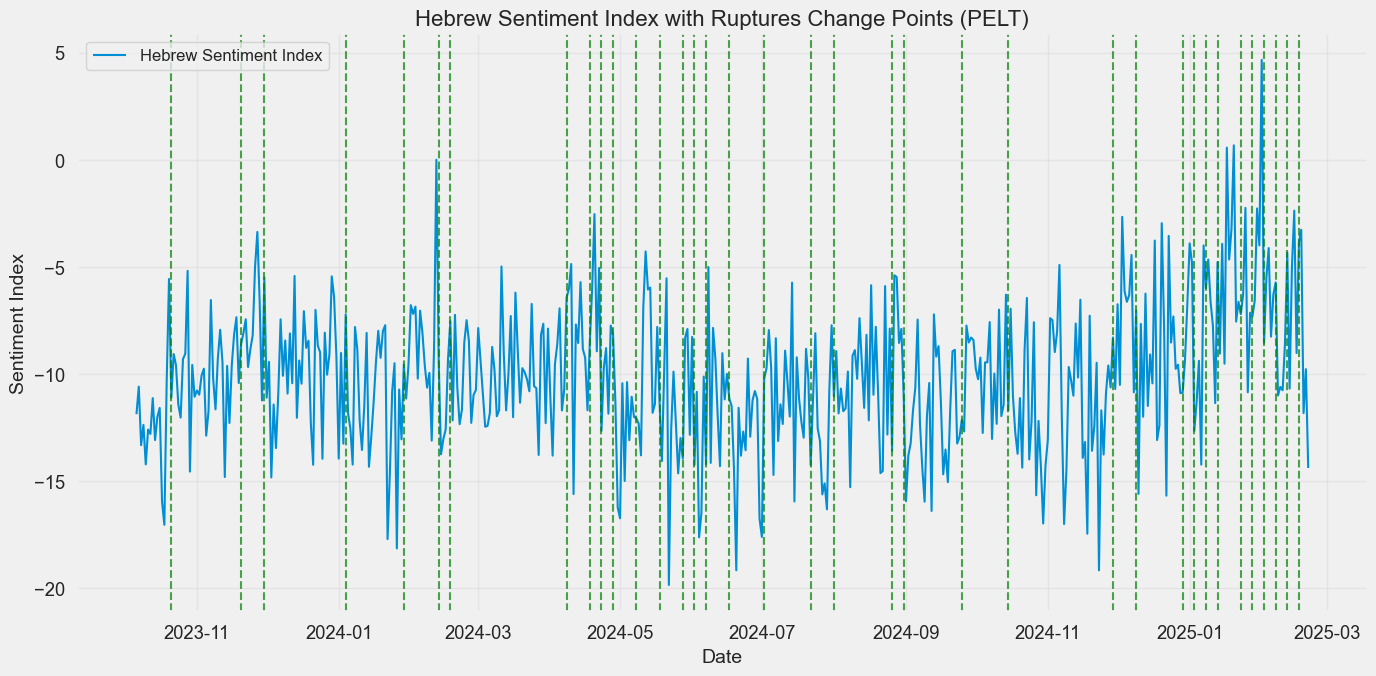

Detected 36 change points in Hebrew sentiment using Ruptures:
- 2023-10-21
- 2023-11-20
- 2023-11-30
- 2024-01-04
- 2024-01-29
- 2024-02-13
- 2024-02-18
- 2024-04-08
- 2024-04-18
- 2024-04-23
- 2024-04-28
- 2024-05-08
- 2024-05-18
- 2024-05-28
- 2024-06-02
- 2024-06-07
- 2024-06-17
- 2024-07-02
- 2024-07-22
- 2024-08-01
- 2024-08-26
- 2024-08-31
- 2024-09-25
- 2024-10-15
- 2024-11-29
- 2024-12-09
- 2024-12-29
- 2025-01-03
- 2025-01-08
- 2025-01-13
- 2025-01-23
- 2025-01-28
- 2025-02-02
- 2025-02-07
- 2025-02-12
- 2025-02-17


In [26]:
# Apply Ruptures to Hebrew sentiment data
hebrew_ruptures_cp = ruptures_changepoint_detection(
    hebrew_ts, method='pelt', penalty=10
)

# Visualize the change points
plt.figure(figsize=(14, 7))
plt.plot(timestamps, hebrew_ts, label='Hebrew Sentiment Index')

# Highlight change points from Ruptures
for cp in hebrew_ruptures_cp:
    if cp < len(timestamps):
        plt.axvline(x=timestamps[cp], color='g', linestyle='--', alpha=0.7)

plt.title('Hebrew Sentiment Index with Ruptures Change Points (PELT)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Index', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Print detected change points
print(f"Detected {len(hebrew_ruptures_cp)} change points in Hebrew sentiment using Ruptures:")
for cp in hebrew_ruptures_cp:
    if cp < len(timestamps):
        print(f"- {timestamps[cp].date()}")


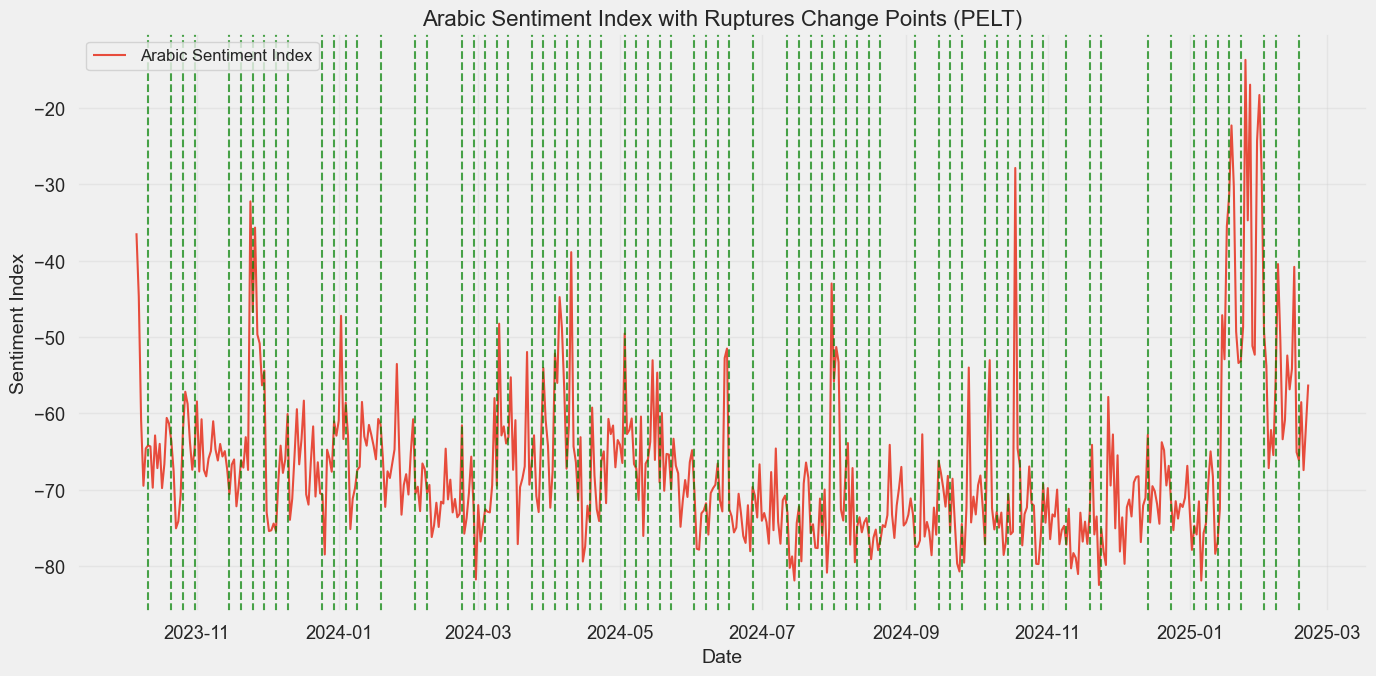

Detected 71 change points in Arabic sentiment using Ruptures:
- 2023-10-11
- 2023-10-21
- 2023-10-26
- 2023-10-31
- 2023-11-15
- 2023-11-20
- 2023-11-25
- 2023-11-30
- 2023-12-05
- 2023-12-10
- 2023-12-25
- 2023-12-30
- 2024-01-04
- 2024-01-09
- 2024-01-19
- 2024-02-03
- 2024-02-08
- 2024-02-23
- 2024-02-28
- 2024-03-04
- 2024-03-09
- 2024-03-14
- 2024-03-24
- 2024-03-29
- 2024-04-03
- 2024-04-08
- 2024-04-13
- 2024-04-18
- 2024-04-23
- 2024-05-03
- 2024-05-08
- 2024-05-13
- 2024-05-18
- 2024-05-23
- 2024-06-02
- 2024-06-07
- 2024-06-12
- 2024-06-17
- 2024-06-27
- 2024-07-12
- 2024-07-17
- 2024-07-22
- 2024-07-27
- 2024-08-01
- 2024-08-06
- 2024-08-11
- 2024-08-16
- 2024-08-21
- 2024-09-05
- 2024-09-15
- 2024-09-20
- 2024-09-25
- 2024-10-05
- 2024-10-10
- 2024-10-15
- 2024-10-20
- 2024-10-25
- 2024-10-30
- 2024-11-09
- 2024-11-19
- 2024-11-24
- 2024-12-14
- 2024-12-24
- 2025-01-03
- 2025-01-08
- 2025-01-13
- 2025-01-18
- 2025-01-23
- 2025-02-02
- 2025-02-07
- 2025-02-17


In [27]:
# Apply Ruptures to Arabic sentiment data
arabic_ruptures_cp = ruptures_changepoint_detection(
    arabic_ts, method='pelt', penalty=10
)

# Visualize the change points
plt.figure(figsize=(14, 7))
plt.plot(timestamps, arabic_ts, color='#e74c3c', label='Arabic Sentiment Index')

# Highlight change points from Ruptures
for cp in arabic_ruptures_cp:
    if cp < len(timestamps):
        plt.axvline(x=timestamps[cp], color='g', linestyle='--', alpha=0.7)

plt.title('Arabic Sentiment Index with Ruptures Change Points (PELT)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Index', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Print detected change points
print(f"Detected {len(arabic_ruptures_cp)} change points in Arabic sentiment using Ruptures:")
for cp in arabic_ruptures_cp:
    if cp < len(timestamps):
        print(f"- {timestamps[cp].date()}")

# Time-lagged Cross-Correlation Analysis

Time-lagged cross-correlation helps us understand how sentiment in one channel influences or correlates with sentiment in another channel over time:


In [28]:
def time_lagged_cross_correlation(series1, series2, max_lag=20):
    """
    Performs time-lagged cross-correlation analysis between two time series.

    Parameters:
    -----------
    series1 : array-like
        First time series
    series2 : array-like
        Second time series
    max_lag : int, default=20
        Maximum lag to consider

    Returns:
    --------
    lags : array
        Lag values from -max_lag to max_lag
    ccf_values : array
        Cross-correlation values for each lag
    max_corr : float
        Maximum correlation value
    max_lag : int
        Lag at which maximum correlation occurs
    """
    # Ensure series are numpy arrays
    series1 = np.asarray(series1)
    series2 = np.asarray(series2)

    # Calculate cross-correlation
    ccf_values = signal.correlate(series1 - np.mean(series1),
                                 series2 - np.mean(series2),
                                 mode='full')

    # Normalize
    ccf_values = ccf_values / (len(series1) * np.std(series1) * np.std(series2))

    # Calculate lags
    lags = np.arange(-max_lag, max_lag + 1)
    mid_idx = len(ccf_values) // 2
    ccf_values = ccf_values[mid_idx - max_lag:mid_idx + max_lag + 1]

    # Find maximum correlation and its lag
    max_idx = np.argmax(np.abs(ccf_values))
    max_corr = ccf_values[max_idx]
    max_corr_lag = lags[max_idx]

    return lags, ccf_values, max_corr, max_corr_lag

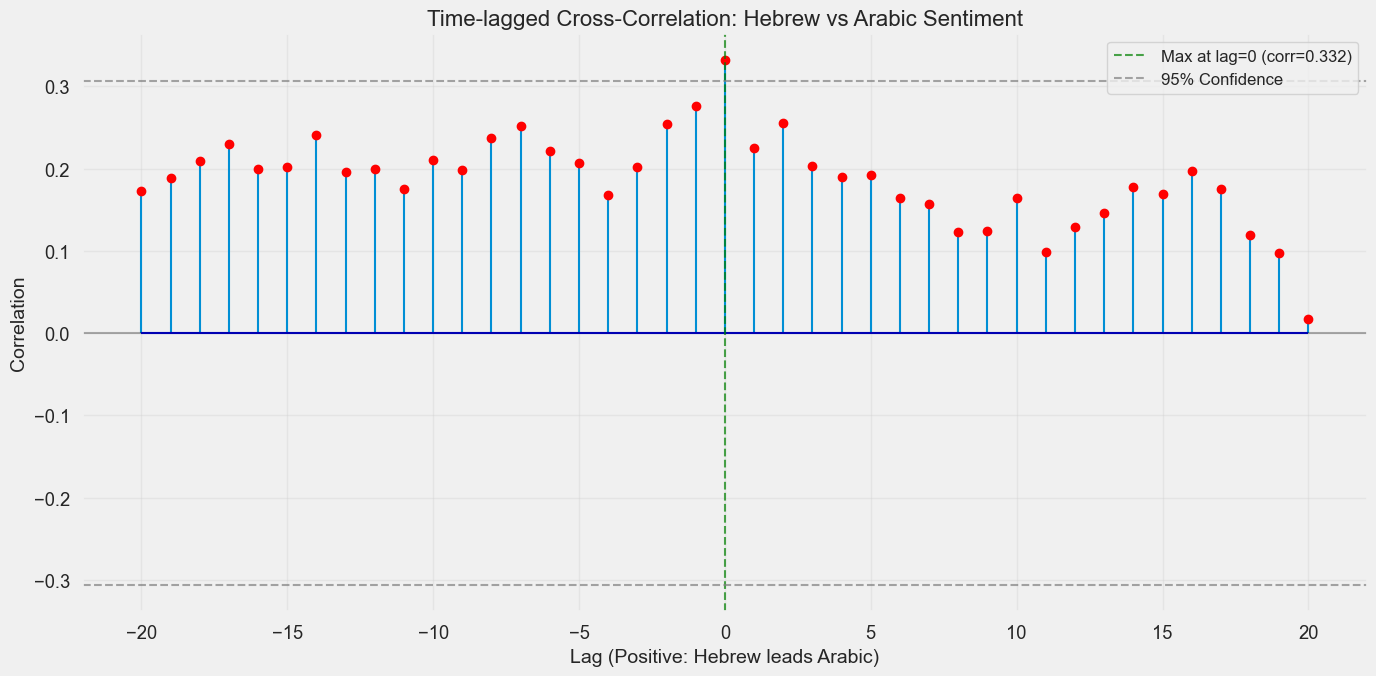

Hebrew and Arabic sentiment changes occur simultaneously (correlation: 0.332)
Correlation at zero lag: 0.332


In [29]:
# Perform time-lagged cross-correlation between Hebrew and Arabic sentiment
max_lag = 20  # Maximum lag in days
lags, ccf_values, max_corr, max_corr_lag = time_lagged_cross_correlation(
    hebrew_ts, arabic_ts, max_lag=max_lag
)

# Visualize the cross-correlation
plt.figure(figsize=(14, 7))
plt.stem(lags, ccf_values, markerfmt='ro', basefmt='b-')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=max_corr_lag, color='green', linestyle='--', alpha=0.7,
            label=f"Max at lag={max_corr_lag} (corr={max_corr:.3f})")

# Add significance bounds (95% confidence)
conf_level = 1.96 / np.sqrt(len(ccf_values))
plt.axhline(y=conf_level, color='gray', linestyle='--', alpha=0.7, label='95% Confidence')
plt.axhline(y=-conf_level, color='gray', linestyle='--', alpha=0.7)

plt.title('Time-lagged Cross-Correlation: Hebrew vs Arabic Sentiment', fontsize=16)
plt.xlabel('Lag (Positive: Hebrew leads Arabic)', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpret the results
if max_corr_lag > 0:
    print(f"Hebrew sentiment changes precede Arabic sentiment changes by {max_corr_lag} days (correlation: {max_corr:.3f})")
elif max_corr_lag < 0:
    print(f"Arabic sentiment changes precede Hebrew sentiment changes by {abs(max_corr_lag)} days (correlation: {max_corr:.3f})")
else:
    print(f"Hebrew and Arabic sentiment changes occur simultaneously (correlation: {max_corr:.3f})")

# Check correlation at zero lag
zero_lag_idx = np.where(lags == 0)[0][0]
zero_lag_corr = ccf_values[zero_lag_idx]
print(f"Correlation at zero lag: {zero_lag_corr:.3f}")

# Comprehensive Analysis Across Metrics
Extend analysis to other metrics like message volume, percentage of positive/negative sentiment, etc

Cross-Correlation Results by Metric:
            metric  max_correlation  lag_at_max  correlation_at_zero_lag
2   message_volume         0.577484           0                 0.577484
1    net_sentiment         0.332314           0                 0.332314
0  sentiment_index         0.332314           0                 0.332314
4     pct_negative         0.255949           0                 0.255949
3     pct_positive         0.203999           3                 0.186770


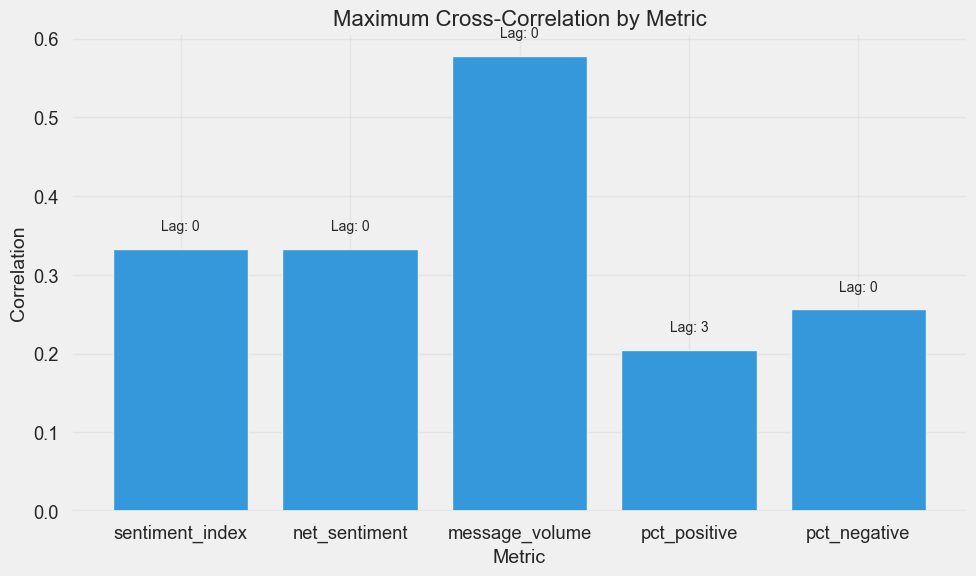

In [30]:
# Define metrics to analyze
metrics = ['sentiment_index', 'net_sentiment', 'message_volume', 'pct_positive', 'pct_negative']

# Create a DataFrame to store cross-correlation results
corr_results = []

# Analyze cross-correlation for each metric
for metric in metrics:
    if metric in hebrew_daily.columns and metric in arabic_daily.columns:
        hebrew_ts = hebrew_daily[metric].values
        arabic_ts = arabic_daily[metric].values

        # Time-lagged cross-correlation
        lags, ccf_values, max_corr, max_corr_lag = time_lagged_cross_correlation(
            hebrew_ts, arabic_ts, max_lag=max_lag
        )

        # Store results
        corr_results.append({
            'metric': metric,
            'max_correlation': max_corr,
            'lag_at_max': max_corr_lag,
            'correlation_at_zero_lag': ccf_values[np.where(lags == 0)[0][0]]
        })

# Create correlation DataFrame
corr_df = pd.DataFrame(corr_results)

# Display results
print("Cross-Correlation Results by Metric:")
print(corr_df.sort_values(by='max_correlation', key=abs, ascending=False))

# Plot correlation by metric
plt.figure(figsize=(10, 6))
bars = plt.bar(corr_df['metric'], corr_df['max_correlation'], color=[
    '#3498db' if x > 0 else '#e74c3c' for x in corr_df['max_correlation']
])

# Add lag information
for i, bar in enumerate(bars):
    height = bar.get_height()
    lag = corr_df.iloc[i]['lag_at_max']
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.02 * (1 if height > 0 else -1),
             f'Lag: {lag}',
             ha='center', va='bottom' if height > 0 else 'top',
             fontsize=10)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Maximum Cross-Correlation by Metric', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identify Significant Events
Identify the most significant events by looking at days where multiple metrics and detection methods identified change points

In [32]:
# Extract all changepoints from daily data
all_changepoints = []

# Store Hebrew CUSUM change points
for metric in metrics:
    if metric in hebrew_daily.columns:
        hebrew_ts = hebrew_daily[metric].values
        cp_indices, _, _ = cusum_changepoint_detection(hebrew_ts, threshold=1.0)

        for cp in cp_indices:
            if cp < len(hebrew_daily):
                all_changepoints.append({
                    'date': hebrew_daily['time_period'].iloc[cp],
                    'method': 'CUSUM',
                    'metric': metric,
                    'language': 'Hebrew'
                })

# Store Arabic CUSUM change points
for metric in metrics:
    if metric in arabic_daily.columns:
        arabic_ts = arabic_daily[metric].values
        cp_indices, _, _ = cusum_changepoint_detection(arabic_ts, threshold=1.0)

        for cp in cp_indices:
            if cp < len(arabic_daily):
                all_changepoints.append({
                    'date': arabic_daily['time_period'].iloc[cp],
                    'method': 'CUSUM',
                    'metric': metric,
                    'language': 'Arabic'
                })

# Store Hebrew Ruptures change points
for metric in metrics:
    if metric in hebrew_daily.columns:
        hebrew_ts = hebrew_daily[metric].values
        cp_indices = ruptures_changepoint_detection(hebrew_ts, method='pelt', penalty=10)

        for cp in cp_indices:
            if cp < len(hebrew_daily):
                all_changepoints.append({
                    'date': hebrew_daily['time_period'].iloc[cp],
                    'method': 'Ruptures',
                    'metric': metric,
                    'language': 'Hebrew'
                })

# Store Arabic Ruptures change points
for metric in metrics:
    if metric in arabic_daily.columns:
        arabic_ts = arabic_daily[metric].values
        cp_indices = ruptures_changepoint_detection(arabic_ts, method='pelt', penalty=10)

        for cp in cp_indices:
            if cp < len(arabic_daily):
                all_changepoints.append({
                    'date': arabic_daily['time_period'].iloc[cp],
                    'method': 'Ruptures',
                    'metric': metric,
                    'language': 'Arabic'
                })

# Convert to DataFrame
cp_df = pd.DataFrame(all_changepoints)


In [33]:
    # Count occurrences of each date
date_counts = cp_df['date'].value_counts().reset_index()
date_counts.columns = ['date', 'count']

# Get top dates with most change point detections
top_n = 10
top_dates = date_counts.sort_values('count', ascending=False).head(top_n)

# Print top dates
print(f"Top {top_n} dates with most change point detections:")
print(top_dates)

plt.show()

Top 10 dates with most change point detections:
          date  count
5   2024-10-15     19
4   2025-02-07     19
6   2024-06-17     19
2   2023-11-30     19
3   2025-02-02     19
0   2025-01-13     19
1   2024-06-07     19
9   2024-04-08     18
12  2024-04-23     18
8   2023-10-21     18


In [34]:
# Get details for top dates
significant_events = []

for _, row in top_dates.iterrows():
    date = row['date']
    count = row['count']

    # Get Hebrew and Arabic sentiment on this date
    hebrew_idx = hebrew_daily[hebrew_daily['time_period'] == date].index
    arabic_idx = arabic_daily[arabic_daily['time_period'] == date].index

    if len(hebrew_idx) > 0 and len(arabic_idx) > 0:
        hebrew_idx = hebrew_idx[0]
        arabic_idx = arabic_idx[0]

        # Get metrics for this date
        hebrew_sentiment = hebrew_daily.loc[hebrew_idx, 'sentiment_index']
        arabic_sentiment = arabic_daily.loc[arabic_idx, 'sentiment_index']
        hebrew_msg_vol = hebrew_daily.loc[hebrew_idx, 'message_volume']
        arabic_msg_vol = arabic_daily.loc[arabic_idx, 'message_volume']

        # Get methods that detected this date
        methods = cp_df[cp_df['date'] == date]['method'].unique()
        metrics = cp_df[cp_df['date'] == date]['metric'].unique()

        significant_events.append({
            'date': date,
            'detection_count': count,
            'methods': ', '.join(methods),
            'metrics': ', '.join(metrics),
            'hebrew_sentiment': hebrew_sentiment,
            'arabic_sentiment': arabic_sentiment,
            'hebrew_messages': hebrew_msg_vol,
            'arabic_messages': arabic_msg_vol
        })

# Create DataFrame
sig_events_df = pd.DataFrame(significant_events)

# Display significant events
print("\nDetails of significant events:")
print(sig_events_df[['date', 'detection_count', 'methods', 'metrics',
                     'hebrew_sentiment', 'arabic_sentiment']])


Details of significant events:
         date  detection_count          methods  \
0  2024-10-15               19  CUSUM, Ruptures   
1  2025-02-07               19  CUSUM, Ruptures   
2  2024-06-17               19  CUSUM, Ruptures   
3  2023-11-30               19  CUSUM, Ruptures   
4  2025-02-02               19  CUSUM, Ruptures   
5  2025-01-13               19  CUSUM, Ruptures   
6  2024-06-07               19  CUSUM, Ruptures   
7  2024-04-08               18  CUSUM, Ruptures   
8  2024-04-23               18  CUSUM, Ruptures   
9  2023-10-21               18  CUSUM, Ruptures   

                                             metrics  hebrew_sentiment  \
0  sentiment_index, net_sentiment, message_volume...        -11.700183   
1  sentiment_index, net_sentiment, message_volume...         -5.726872   
2  sentiment_index, net_sentiment, message_volume...        -11.158798   
3  sentiment_index, net_sentiment, message_volume...         -5.500000   
4  sentiment_index, net_sentiment, m

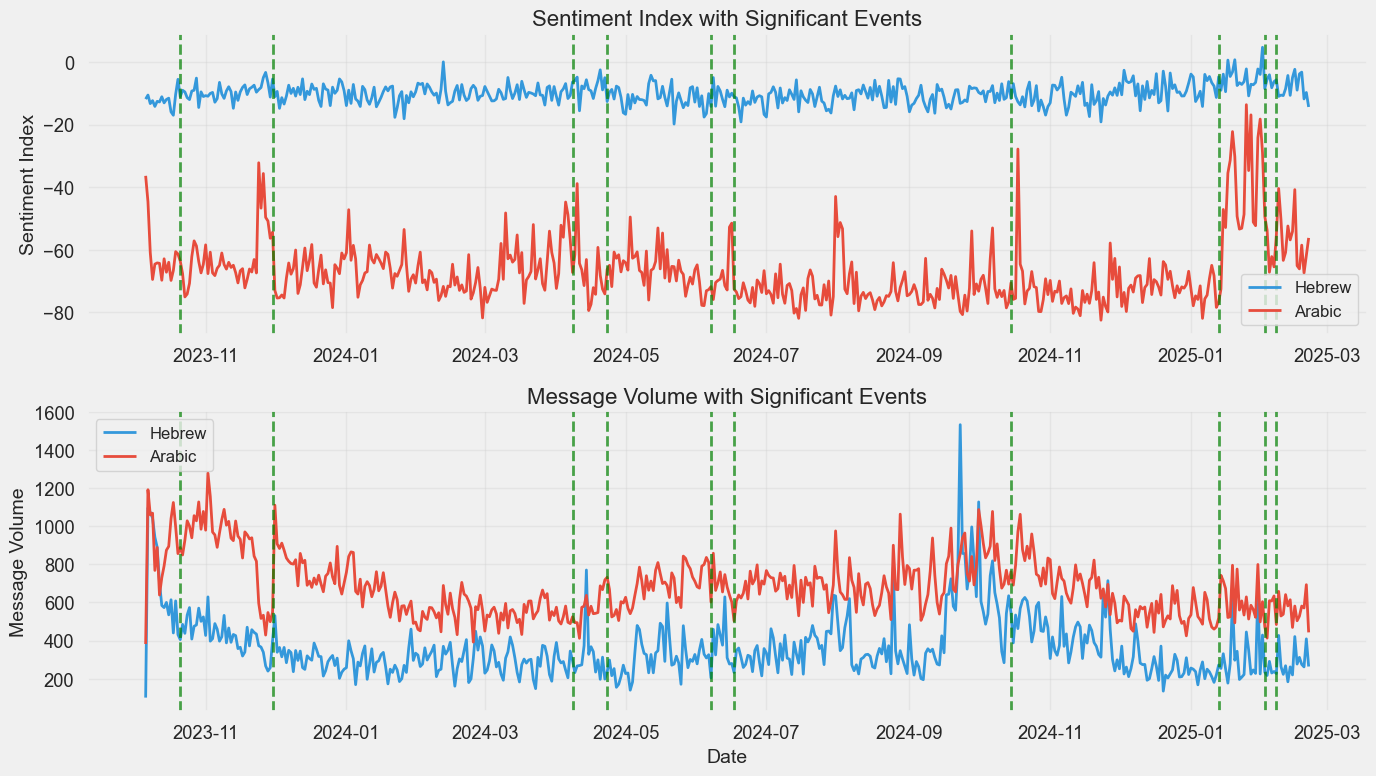

In [35]:
# Visualize significant events
plt.figure(figsize=(14, 8))

# Plot sentiment with highlighted significant events
plt.subplot(211)
plt.plot(pd.to_datetime(hebrew_daily['time_period']), hebrew_daily['sentiment_index'],
         color='#3498db', linewidth=2, label='Hebrew')
plt.plot(pd.to_datetime(arabic_daily['time_period']), arabic_daily['sentiment_index'],
         color='#e74c3c', linewidth=2, label='Arabic')

# Highlight significant events
for date in sig_events_df['date']:
    plt.axvline(x=pd.to_datetime(date), color='green', linestyle='--', linewidth=2, alpha=0.7)

plt.title('Sentiment Index with Significant Events', fontsize=16)
plt.ylabel('Sentiment Index', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Plot message volume with highlighted significant events
plt.subplot(212)
plt.plot(pd.to_datetime(hebrew_daily['time_period']), hebrew_daily['message_volume'],
         color='#3498db', linewidth=2, label='Hebrew')
plt.plot(pd.to_datetime(arabic_daily['time_period']), arabic_daily['message_volume'],
         color='#e74c3c', linewidth=2, label='Arabic')

# Highlight significant events
for date in sig_events_df['date']:
    plt.axvline(x=pd.to_datetime(date), color='green', linestyle='--', linewidth=2, alpha=0.7)

plt.title('Message Volume with Significant Events', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Message Volume', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()


## Sentiment Index with Significant Events

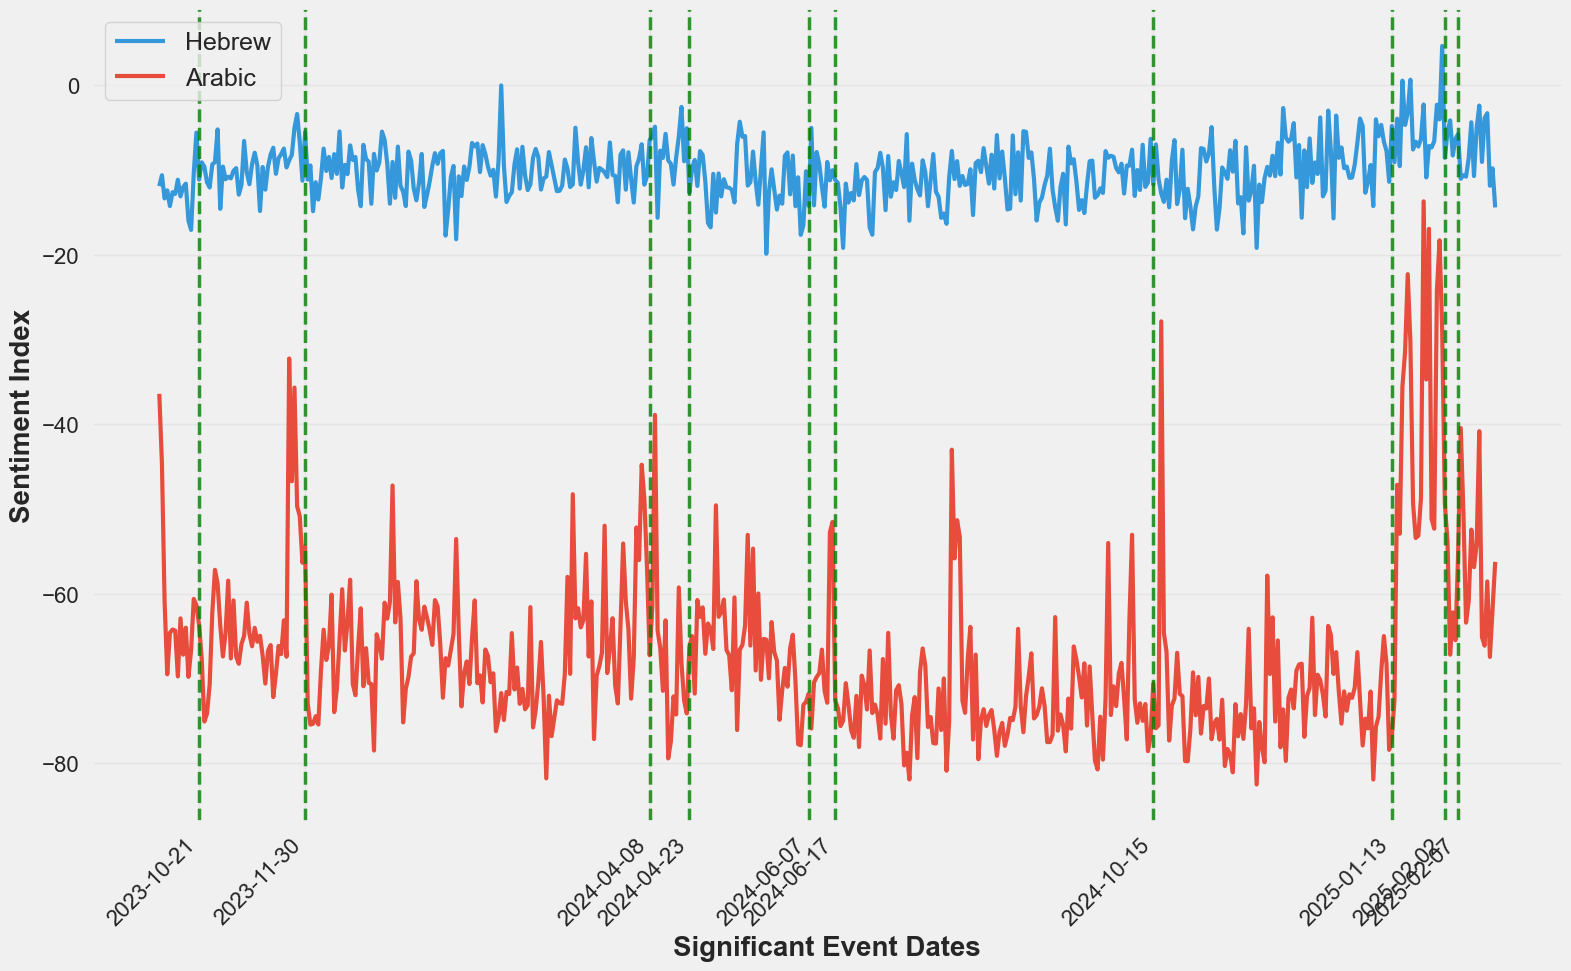

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import rcParams

# Increase default font sizes globally
rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 24
rcParams['axes.labelsize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 18
rcParams['figure.titlesize'] = 26

# Create the plot
plt.figure(figsize=(16, 10))

# Plot sentiment with highlighted significant events
plt.plot(pd.to_datetime(hebrew_daily['time_period']), hebrew_daily['sentiment_index'],
         color='#3498db', linewidth=3, label='Hebrew')
plt.plot(pd.to_datetime(arabic_daily['time_period']), arabic_daily['sentiment_index'],
         color='#e74c3c', linewidth=3, label='Arabic')

# Highlight significant events with vertical lines and add more visual emphasis
for date in sig_events_df['date']:
    plt.axvline(x=pd.to_datetime(date), color='green', linestyle='--', linewidth=2.5, alpha=0.8)

# Add event descriptions as labels if available in the dataframe
if 'description' in sig_events_df.columns:
    # Create labels for the significant events
    for i, row in sig_events_df.iterrows():
        date = pd.to_datetime(row['date'])
        description = row['description'] if 'description' in row else f"Event {i+1}"

        # Find the y-position for the annotation (use average sentiment value at that date)
        y_pos = 0  # Default position
        closest_hebrew = hebrew_daily[pd.to_datetime(hebrew_daily['time_period']).dt.date == date.date()]
        closest_arabic = arabic_daily[pd.to_datetime(arabic_daily['time_period']).dt.date == date.date()]

        if not closest_hebrew.empty and not closest_arabic.empty:
            # Use the max sentiment value for better visibility
            y_pos = max(closest_hebrew['sentiment_index'].iloc[0], closest_arabic['sentiment_index'].iloc[0])
            # Add a small offset to avoid overlap with the lines
            y_pos = y_pos + 0.05
        elif not closest_hebrew.empty:
            y_pos = closest_hebrew['sentiment_index'].iloc[0] + 0.05
        elif not closest_arabic.empty:
            y_pos = closest_arabic['sentiment_index'].iloc[0] + 0.05

# Format dates on x-axis to show only significant event dates
ax = plt.gca()
# Convert significant event dates to datetime objects
sig_dates = [pd.to_datetime(date) for date in sig_events_df['date']]
# Set these dates as the tick locations
ax.set_xticks(sig_dates)
# Format the dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Rotate date labels for better readability
plt.gcf().autofmt_xdate(rotation=45)

# Add titles and labels with larger font sizes
# plt.title('Sentiment Index with Significant Events', fontweight='bold', pad=20)
plt.ylabel('Sentiment Index', fontweight='bold')
plt.xlabel('Significant Event Dates', fontweight='bold')

# Add a grid for better readability
plt.grid(True, alpha=0.3)

# Create a legend with a larger font size
plt.legend(loc='best', frameon=True, framealpha=0.8)

# Adjust layout to ensure everything fits properly
plt.tight_layout()

# Save the figure as a high-resolution PDF
plt.savefig('../figs/sentiment_index_significant_events.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [41]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Function to print summary statistics
def print_summary_statistics():
    print("\n" + "="*80)
    print("SENTIMENT ANALYSIS SUMMARY STATISTICS".center(80))
    print("="*80 + "\n")

    # Summary statistics for Hebrew sentiment
    print("HEBREW SENTIMENT STATISTICS:")
    print("-"*50)
    hebrew_stats = {
        "Mean Sentiment": hebrew_daily['sentiment_index'].mean(),
        "Median Sentiment": hebrew_daily['sentiment_index'].median(),
        "Min Sentiment": hebrew_daily['sentiment_index'].min(),
        "Max Sentiment": hebrew_daily['sentiment_index'].max(),
        "Standard Deviation": hebrew_daily['sentiment_index'].std(),
        "Total Messages": hebrew_daily['message_volume'].sum()
    }

    for stat, value in hebrew_stats.items():
        print(f"{stat:.<30} {value:.4f}")

    print("\nARABIC SENTIMENT STATISTICS:")
    print("-"*50)
    arabic_stats = {
        "Mean Sentiment": arabic_daily['sentiment_index'].mean(),
        "Median Sentiment": arabic_daily['sentiment_index'].median(),
        "Min Sentiment": arabic_daily['sentiment_index'].min(),
        "Max Sentiment": arabic_daily['sentiment_index'].max(),
        "Standard Deviation": arabic_daily['sentiment_index'].std(),
        "Total Messages": arabic_daily['message_volume'].sum()
    }

    for stat, value in arabic_stats.items():
        print(f"{stat:.<30} {value:.4f}")

# Function to print sentiment around significant events
def print_significant_event_analysis():
    print("\n" + "="*80)
    print("SENTIMENT CHANGES AROUND SIGNIFICANT EVENTS".center(80))
    print("="*80 + "\n")

    # Create a table to display sentiment changes around events
    event_data = []

    # Loop through each significant event
    for i, row in sig_events_df.iterrows():
        event_date = pd.to_datetime(row['date'])
        event_description = row['description'] if 'description' in row.index else f"Event {i+1}"

        # Define time windows (7 days before and after the event)
        before_start = event_date - timedelta(days=7)
        after_end = event_date + timedelta(days=7)

        # Get sentiment data for before and after periods
        hebrew_before = hebrew_daily[(pd.to_datetime(hebrew_daily['time_period']) >= before_start) &
                                    (pd.to_datetime(hebrew_daily['time_period']) < event_date)]
        hebrew_after = hebrew_daily[(pd.to_datetime(hebrew_daily['time_period']) > event_date) &
                                   (pd.to_datetime(hebrew_daily['time_period']) <= after_end)]

        arabic_before = arabic_daily[(pd.to_datetime(arabic_daily['time_period']) >= before_start) &
                                    (pd.to_datetime(arabic_daily['time_period']) < event_date)]
        arabic_after = arabic_daily[(pd.to_datetime(arabic_daily['time_period']) > event_date) &
                                   (pd.to_datetime(arabic_daily['time_period']) <= after_end)]

        # Calculate average sentiment before and after
        hebrew_before_avg = hebrew_before['sentiment_index'].mean() if not hebrew_before.empty else np.nan
        hebrew_after_avg = hebrew_after['sentiment_index'].mean() if not hebrew_after.empty else np.nan
        hebrew_change = hebrew_after_avg - hebrew_before_avg if not (np.isnan(hebrew_before_avg) or np.isnan(hebrew_after_avg)) else np.nan

        arabic_before_avg = arabic_before['sentiment_index'].mean() if not arabic_before.empty else np.nan
        arabic_after_avg = arabic_after['sentiment_index'].mean() if not arabic_after.empty else np.nan
        arabic_change = arabic_after_avg - arabic_before_avg if not (np.isnan(arabic_before_avg) or np.isnan(arabic_after_avg)) else np.nan

        # Add to the event data table
        event_data.append([
            event_date.strftime('%Y-%m-%d'),
            event_description,
            f"{hebrew_before_avg:.4f}" if not np.isnan(hebrew_before_avg) else "N/A",
            f"{hebrew_after_avg:.4f}" if not np.isnan(hebrew_after_avg) else "N/A",
            f"{hebrew_change:.4f}" if not np.isnan(hebrew_change) else "N/A",
            f"{arabic_before_avg:.4f}" if not np.isnan(arabic_before_avg) else "N/A",
            f"{arabic_after_avg:.4f}" if not np.isnan(arabic_after_avg) else "N/A",
            f"{arabic_change:.4f}" if not np.isnan(arabic_change) else "N/A"
        ])

    # Print the table
    headers = [
        "Event Date",
        "Description",
        "Hebrew Before",
        "Hebrew After",
        "Hebrew Change",
        "Arabic Before",
        "Arabic After",
        "Arabic Change"
    ]

    print(tabulate(event_data, headers=headers, tablefmt="grid"))

# Function to find correlation between Hebrew and Arabic sentiment
def print_correlation_analysis():
    print("\n" + "="*80)
    print("CORRELATION ANALYSIS".center(80))
    print("="*80 + "\n")

    # Merge Hebrew and Arabic dataframes on time_period
    merged_df = pd.merge(
        hebrew_daily[['time_period', 'sentiment_index', 'message_volume']],
        arabic_daily[['time_period', 'sentiment_index', 'message_volume']],
        on='time_period',
        suffixes=('_hebrew', '_arabic')
    )

    # Calculate correlation between Hebrew and Arabic sentiment
    sentiment_corr = merged_df['sentiment_index_hebrew'].corr(merged_df['sentiment_index_arabic'])
    volume_corr = merged_df['message_volume_hebrew'].corr(merged_df['message_volume_arabic'])

    print(f"Correlation between Hebrew and Arabic sentiment: {sentiment_corr:.4f}")
    print(f"Correlation between Hebrew and Arabic message volume: {volume_corr:.4f}")

    # Calculate time-lagged correlations (if one sentiment leads the other)
    print("\nTIME-LAGGED CORRELATIONS:")
    print("-"*50)

    max_lag = 5  # Check correlations up to 5 days lag
    lag_correlations = []

    for lag in range(-max_lag, max_lag+1):
        if lag == 0:
            continue  # Already calculated above

        # Shift Arabic sentiment by 'lag' days
        merged_df['arabic_shifted'] = merged_df['sentiment_index_arabic'].shift(lag)

        # Calculate correlation
        lag_corr = merged_df['sentiment_index_hebrew'].corr(merged_df['arabic_shifted'])
        lag_correlations.append((lag, lag_corr))

    # Print lag correlations
    for lag, corr in lag_correlations:
        if lag < 0:
            print(f"Hebrew sentiment leading Arabic by {abs(lag)} days: {corr:.4f}")
        else:
            print(f"Arabic sentiment leading Hebrew by {lag} days: {corr:.4f}")


# Execute all analysis functions and save results
import sys

# Print to console
print_summary_statistics()
print_significant_event_analysis()
print_correlation_analysis()


                     SENTIMENT ANALYSIS SUMMARY STATISTICS                      

HEBREW SENTIMENT STATISTICS:
--------------------------------------------------
Mean Sentiment................ -10.1009
Median Sentiment.............. -10.2296
Min Sentiment................. -19.8556
Max Sentiment................. 4.6620
Standard Deviation............ 3.3231
Total Messages................ 183581.0000

ARABIC SENTIMENT STATISTICS:
--------------------------------------------------
Mean Sentiment................ -67.1805
Median Sentiment.............. -69.4241
Min Sentiment................. -82.4759
Max Sentiment................. -13.6725
Standard Deviation............ 10.2261
Total Messages................ 345118.0000

                  SENTIMENT CHANGES AROUND SIGNIFICANT EVENTS                   

+--------------+---------------+-----------------+----------------+-----------------+-----------------+----------------+-----------------+
| Event Date   | Description   |   Hebrew Before |   

# Generate Summary Report

In [37]:
# Create a summary DataFrame of all events
all_events = pd.DataFrame(all_changepoints)

# Get counts by language
lang_counts = all_events['language'].value_counts()
print("Change points by language:")
print(lang_counts)

# Get counts by method
method_counts = all_events['method'].value_counts()
print("\nChange points by method:")
print(method_counts)

# Get counts by metric
metric_counts = all_events['metric'].value_counts()
print("\nChange points by metric:")
print(metric_counts)

# Create a pivot table of event counts by date and language
pivot_by_date_lang = pd.pivot_table(
    all_events,
    index='date',
    columns='language',
    values='metric',
    aggfunc='count',
    fill_value=0
)

# # Plot counts by language
# plt.figure(figsize=(14, 7))
# pivot_by_date_lang.plot(kind='bar', figsize=(14, 7))
# plt.title('Detected Events by Date and Language', fontsize=16)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Number of Detections', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


Change points by language:
language
Arabic    2854
Hebrew    2718
Name: count, dtype: int64

Change points by method:
method
CUSUM       5034
Ruptures     538
Name: count, dtype: int64

Change points by metric:
metric
message_volume     1204
sentiment_index    1114
net_sentiment      1114
pct_negative       1097
pct_positive       1043
Name: count, dtype: int64


## Save significant events

In [19]:
# Save significant events to CSV
sig_events_df.to_csv(f"../data/sentiment_temporal/significant_events.csv", index=False)
print(f"\nSaved significant events to data/sentiment_temporal/significant_events.csv")

# Save cross-correlation results to CSV
corr_df.to_csv(f"../data/sentiment_temporal/events_cross_correlation.csv", index=False)
print(f"Saved cross-correlation results to data/sentiment_temporal/events_cross_correlation.csv")


Saved significant events to data/sentiment_temporal/significant_events.csv
Saved cross-correlation results to data/sentiment_temporal/events_cross_correlation.csv
